In [1]:
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
# url = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/housing/housing.csv"
# urllib.request.urlretrieve(url,"housing.csv")
housing = pd.read_csv("datasets/housing.csv");
housing.info()
RANDSTATE = 42

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


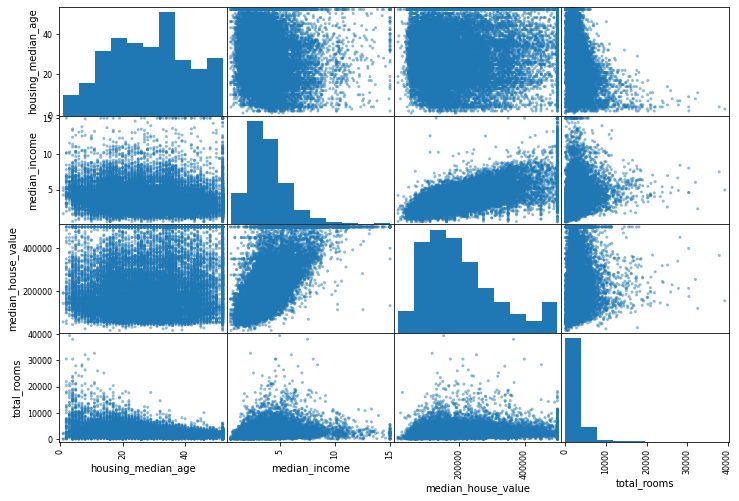

In [2]:
# EDA, scatterplot matrix
from pandas.plotting import scatter_matrix 
attrs=["housing_median_age","median_income","median_house_value","total_rooms"]
scatter_matrix(housing[attrs],figsize=(12,8));

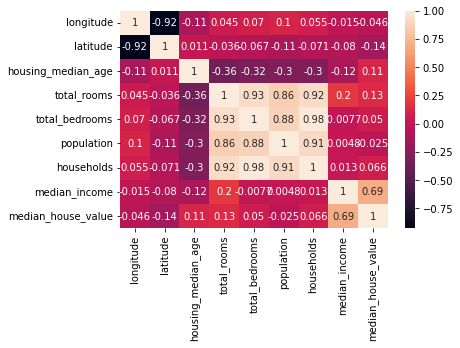

In [3]:
sns.heatmap(housing.corr(),annot=True);

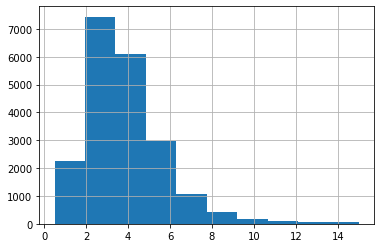

In [4]:
# basic split train/test set
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.8,random_state=RANDSTATE) 
# visualize median_income
housing["median_income"].hist();

181632 45408


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


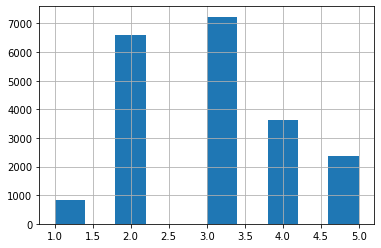

In [5]:
# stratified sample split with median_income
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_category"]=pd.cut(housing["median_income"],
    bins=[0.0,1.5,3.0,4.5,6.0,np.inf],
    labels=[1,2,3,4,5])
housing["income_category"].hist().plot()

strat_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDSTATE)

for train_idx,test_idx in strat_split.split(housing,housing["income_category"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]
print(strat_train_set.size,strat_test_set.size)

# remove column "income_category"
for row in strat_train_set,strat_test_set:
    row.drop("income_category",inplace=True,axis=1)
strat_train_set.head()


In [6]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [7]:
housing["rooms_per_household"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]= housing["population"]/housing["households"]
# drop non-numerical data
housing.drop("total_bedrooms",axis=1)
housing_numerical = housing.drop("ocean_proximity",axis=1)

In [8]:
print(list(housing.columns))
# cols = ["total_rooms", "total_bedrooms", "population", "households"]
# rooms_idx, bedrooms_idx,population_idx,households_idx = [
#     list(housing.columns).index(col) for col in cols
# ]
rooms_idx, bedrooms_idx,population_idx,households_idx=3,4,5,6
print(rooms_idx, bedrooms_idx,population_idx,households_idx)

from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    duck-typed custom tranformer
    fit, transform required
    fit_transform with TransformerMixin

    X,y should be array-like/matrix, not dataframe
    """
    def __init__(self,add_bedrooms_per_room=True) -> None:
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_idx]/X[:,households_idx]
        population_per_household = X[:,population_idx]/X[:,households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room= X[:,bedrooms_idx]/X[:,households_idx]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
3 4 5 6


In [9]:
# numerical data pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
numerical_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("attribs_adder",CombinedAttributesAdder()),
    ("std_scaler",StandardScaler())
])
numerical_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler())])

In [10]:
# apply transformer to columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
full_pipeline = ColumnTransformer([
    ("numerical_pipeline",numerical_pipeline,list(housing_numerical)),
    ("onehotencoder",OneHotEncoder(),['ocean_proximity'])
])
housing_final = full_pipeline.fit_transform(housing)
full_pipeline

ColumnTransformer(transformers=[('numerical_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household', 'bedrooms_per_room',
                                  'population_per_household']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['ocean_proximity'])])

In [11]:
# train linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_final,housing_labels)
pred = lin_reg.predict(housing_final)
rmse = np.sqrt(mean_squared_error(housing_labels,pred))
print(f"RMSE: {rmse}")

RMSE: 68079.21224314625


In [12]:
# train decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_final,housing_labels)
pred = tree_reg.predict(housing_final)
rmse = np.sqrt(mean_squared_error(housing_labels,pred))
print(f"RMSE: {rmse}")

RMSE: 0.0
